In [1]:
# imports 
import h5_utilities_module as h5u
import numpy as np 
import pandas as pd 
import h5py
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from pathlib import Path
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import warnings

In [2]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

def calculate_trajectory_jerk(trajectory, time_window, dimensions=None):
    """Calculate trajectory jerkiness - higher values = less smooth"""
    if dimensions is None:
        # Use all dimensions
        path = trajectory[time_window[0]:time_window[1], :]
    else:
        path = trajectory[time_window[0]:time_window[1], dimensions]
   
    if len(path) < 3:  # Need at least 3 points for jerk calculation
        return np.nan
   
    # First derivative (velocity)
    velocity = np.diff(path, axis=0)
    # Second derivative (acceleration)
    acceleration = np.diff(velocity, axis=0)
   
    # Jerk magnitude at each timepoint
    jerk_magnitude = np.sqrt(np.sum(acceleration**2, axis=1))
   
    return np.mean(jerk_magnitude)  # Average jerkiness

def permutation_test_brain_area_difference(ofc_change, cdn_change, n_permutations=10000):
    """
    Test if CDN shows larger jerkiness increase than OFC using permutation test
    """
    # Observed difference between brain areas
    observed_diff = np.mean(cdn_change) - np.mean(ofc_change)
    
    # Combine all change scores
    all_changes = np.concatenate([ofc_change, cdn_change])
    n_ofc = len(ofc_change)
    n_cdn = len(cdn_change)
    
    # Permutation loop
    perm_diffs = []
    for i in range(n_permutations):
        # Randomly reassign brain area labels
        shuffled = np.random.permutation(all_changes)
        perm_ofc = shuffled[:n_ofc]
        perm_cdn = shuffled[n_ofc:n_ofc+n_cdn]
        
        # Calculate difference under permutation
        perm_diff = np.mean(perm_cdn) - np.mean(perm_ofc)
        perm_diffs.append(perm_diff)
    
    # Calculate p-value (two-tailed)
    perm_diffs = np.array(perm_diffs)
    p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / n_permutations
    
    return observed_diff, p_value, perm_diffs

In [3]:
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)
h5u.list_hdf5_data(data_files[4])

Datasets in 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder\K20240707_Rec06.h5':
CdN_FR
CdN_channels
CdN_lfp
CdN_locations
CdN_mean_wf
CdN_u_names
CdN_zFR
OFC_FR
OFC_channels
OFC_lfp
OFC_locations
OFC_mean_wf
OFC_u_names
OFC_zFR
bhv
chan_map
lfp_ts
ts


In [4]:
this_file = data_files[0]

In [25]:

f_name = Path(this_file).stem
print(f_name)

if 'D' in f_name:
    s = 0
else:
    s = 1


# pull the data for this file
# access the data for this session
ofc_firing_rates = h5u.pull_from_h5(this_file, 'OFC_zFR')
cdn_firing_rates = h5u.pull_from_h5(this_file, 'CdN_zFR')
                        
# figure out how many neurons we have
n_OFC = h5u.pull_from_h5(this_file, 'OFC_zFR').shape[2]
n_CdN = h5u.pull_from_h5(this_file, 'CdN_zFR').shape[2]
brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

# pull out the time step index and the behavior
ts = h5u.pull_from_h5(this_file, 'ts')
bhv = pd.read_hdf(this_file, key='bhv')

# make sure the behavioral data has the same number of trials as the firing rates
if len(bhv) > len(ofc_firing_rates):
    bhv = bhv.loc[0 :len(ofc_firing_rates)-1]

# set any nan values to zero (necessary for the decoder)
ofc_firing_rates = np.nan_to_num(ofc_firing_rates, nan=0)
cdn_firing_rates = np.nan_to_num(cdn_firing_rates, nan=0)

# get indices of the choice period
pics_on = np.argwhere(ts == 25)[0][0]
pics_end = np.argwhere(ts == 400)[0][0]

# get the mean firing rate for the choice period for both brain areas
ofc_choice_frs = np.mean(ofc_firing_rates[:,pics_on:pics_end,:], axis=1)
cdn_choice_frs = np.mean(cdn_firing_rates[:,pics_on:pics_end,:], axis=1)

# get the labels associated with each unique state-value pair
ch_val, unch_val = get_ch_and_unch_vals(bhv)
s_ch_val = ch_val.copy()
s_unch_val = unch_val.copy()

s_ch_val[bhv['state'] == 2] = s_ch_val[bhv['state'] == 2] + 4
s_ch_val[bhv['state'] == 3] = s_ch_val[bhv['state'] == 3] + 8
s_unch_val[bhv['state'] == 2] = s_unch_val[bhv['state'] == 2] + 4
s_unch_val[bhv['state'] == 3] = s_unch_val[bhv['state'] == 3] + 8

n_trials, n_times, n_ofc = np.shape(ofc_firing_rates)


valid_trials = (bhv['forced'] == 1) | (bhv['n_sacc'] == 1) & (bhv['state'] < 3)
train_labels = s_ch_val[valid_trials]
test_trials = ~valid_trials

# train the decoders
ofc_lda = LinearDiscriminantAnalysis()
cdn_lda = LinearDiscriminantAnalysis()

# train the classifier
ofc_lda.fit(ofc_choice_frs[valid_trials, :], train_labels)
cdn_lda.fit(cdn_choice_frs[valid_trials, :], train_labels)

# Get initial LDA projections
choice_ofc_lda_raw = ofc_lda.transform(ofc_choice_frs)
choice_cdn_lda_raw = cdn_lda.transform(cdn_choice_frs)

# Create scalers for LDA dimensions and fit on choice period data
ofc_lda_scaler = StandardScaler()
cdn_lda_scaler = StandardScaler()

# Z-score the choice period LDA projections
choice_ofc_lda_trials = ofc_lda_scaler.fit_transform(choice_ofc_lda_raw)
choice_cdn_lda_trials = cdn_lda_scaler.fit_transform(choice_cdn_lda_raw)

# define all combinations of choice and state
state_val_combinations = np.array([ [1, 1],
                                    [1, 2],
                                    [1, 3],
                                    [1, 4],
                                    [2, 1],
                                    [2, 2],
                                    [2, 3],
                                    [2, 4],
                                    [3, 1],
                                    [3, 2],
                                    [3, 3],
                                    [3, 4]])

# Now project every timestep into LDA space and z-score
ofc_lda_timecourse = np.zeros((n_trials, n_times, len(np.unique(s_ch_val))-1))
cdn_lda_timecourse = np.zeros((n_trials, n_times, len(np.unique(s_ch_val))-1))

for t in range(n_times):
    # Project population activity at timestep t into LDA space
    ofc_t_raw = ofc_lda.transform(ofc_firing_rates[:, t, :])
    cdn_t_raw = cdn_lda.transform(cdn_firing_rates[:, t, :])
    
    # Apply z-scoring using the scalers fit on choice period data
    ofc_lda_timecourse[:, t, :] = ofc_lda_scaler.transform(ofc_t_raw)
    cdn_lda_timecourse[:, t, :] = cdn_lda_scaler.transform(cdn_t_raw)

# calculate the mean location of each value location...
ofc_manifold = np.zeros(shape=(len(state_val_combinations), len(np.unique(s_ch_val))-1))
cdn_manifold = np.zeros(shape=(len(state_val_combinations), len(np.unique(s_ch_val))-1))

for i in range(len(state_val_combinations)):
    ix = (bhv['state'] == state_val_combinations[i,0]) & (bhv['ch_val'] == state_val_combinations[i,1])
    ofc_manifold[i,:] = np.nanmean(choice_ofc_lda_trials[ix, :], axis=0)
    cdn_manifold[i,:] = np.nanmean(choice_cdn_lda_trials[ix, :], axis=0)


# do a boostrap analysis for the jerkiness of the trajectories
# Define condition parameters
state2use = 1
ch_val2use = 2
unchval2use = 1

# Get trial indices
trials_single = (bhv['state'] == state2use) & (bhv['ch_val'] == ch_val2use) & (bhv['n_sacc'] == 1)
trials_double = (bhv['state'] == state2use) & (bhv['ch_val'] == ch_val2use) & (unch_val == unchval2use) & (bhv['n_sacc'] == 2)

single_indices = np.where(trials_single)[0]
double_indices = np.where(trials_double)[0]


# Time windows
pics_on_ix = np.argmin(np.abs(ts - -100))
choice_end_ix_single = np.argmin(np.abs(ts - np.nanmean(bhv['sacc1_t'].loc[trials_single] + 50)))
choice_end_ix_double = np.argmin(np.abs(ts - np.nanmean(bhv['sacc2_t'].loc[trials_double] + 50)))

time_window_single = (pics_on_ix, choice_end_ix_single)
time_window_double = (pics_on_ix, choice_end_ix_double)

# Dimensions
ofc_dimensions = [0, 1, 2]
cdn_dimensions = [0, 1, 2]

# Initialize bootstrap arrays
n_bootstrap = 1000
ofc_single_jerks = []
ofc_double_jerks = []
cdn_single_jerks = []
cdn_double_jerks = []

# Bootstrap loop
for i in range(n_bootstrap):
    # Sample with replacement
    single_sample = np.random.choice(single_indices, size=len(single_indices), replace=True)
    double_sample = np.random.choice(double_indices, size=len(double_indices), replace=True)
    
    # Calculate mean trajectories for this bootstrap sample
    ofc_single_traj = np.nanmean(ofc_lda_timecourse[single_sample,:,:], axis=0)
    ofc_double_traj = np.nanmean(ofc_lda_timecourse[double_sample,:,:], axis=0)
    cdn_single_traj = np.nanmean(cdn_lda_timecourse[single_sample,:,:], axis=0)
    cdn_double_traj = np.nanmean(cdn_lda_timecourse[double_sample,:,:], axis=0)
    
    # Calculate jerkiness
    ofc_single_jerk = calculate_trajectory_jerk(ofc_single_traj, time_window_single, ofc_dimensions)
    ofc_double_jerk = calculate_trajectory_jerk(ofc_double_traj, time_window_double, ofc_dimensions)
    cdn_single_jerk = calculate_trajectory_jerk(cdn_single_traj, time_window_single, cdn_dimensions)
    cdn_double_jerk = calculate_trajectory_jerk(cdn_double_traj, time_window_double, cdn_dimensions)
    
    # Store results
    ofc_single_jerks.append(ofc_single_jerk)
    ofc_double_jerks.append(ofc_double_jerk)
    cdn_single_jerks.append(cdn_single_jerk)
    cdn_double_jerks.append(cdn_double_jerk)

# Convert to arrays
ofc_single_jerks = np.array(ofc_single_jerks)
ofc_double_jerks = np.array(ofc_double_jerks)
cdn_single_jerks = np.array(cdn_single_jerks)
cdn_double_jerks = np.array(cdn_double_jerks)


# Calculate the change scores
ofc_change = ofc_double_jerks - ofc_single_jerks
cdn_change = cdn_double_jerks - cdn_single_jerks

# Run permutation test
observed_diff, p_value, perm_distribution = permutation_test_brain_area_difference(
    ofc_change, cdn_change, n_permutations=10000)


D20231219_Rec05


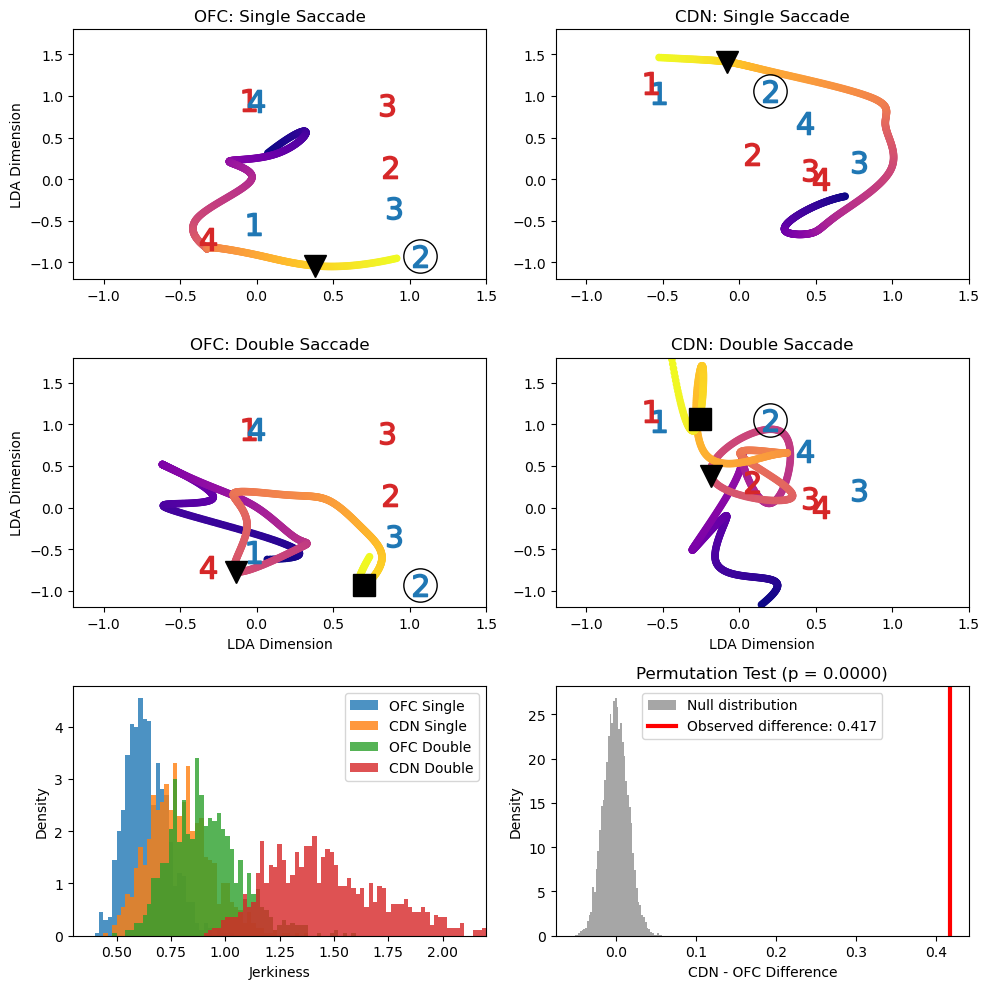

In [ ]:
# Define the condition to plot
state2use = 1
ch_val2use = 2
unchval2use = 1

# Create figure with 2x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Define saccade conditions and titles
saccade_conditions = [1, 2]
saccade_titles = ['Single Saccade', 'Double Saccade']
brain_areas = ['OFC', 'CDN']

for sacc_idx, n_sacc in enumerate(saccade_conditions):
    
    # Define trials for this saccade condition
    if n_sacc == 1:
        trials2use = (bhv['state'] == state2use) & (bhv['ch_val'] == ch_val2use) & (bhv['n_sacc'] == n_sacc)
        choice_end_ix = np.argmin(np.abs(ts - np.nanmean(bhv['sacc1_t'].loc[trials2use] + 50)))
    else:
        trials2use = (bhv['state'] == state2use) & (bhv['ch_val'] == ch_val2use) & (unch_val == unchval2use) & (bhv['n_sacc'] > 1)
        choice_end_ix = np.argmin(np.abs(ts - np.nanmean(bhv['sacc2_t'].loc[trials2use] + 50)))
    
    pics_on_ix = np.argmin(np.abs(ts - -100))
    
    # Get mean trajectories
    ofc_mean_trajectory = np.nanmean(ofc_lda_timecourse[trials2use,:,:], axis=0)
    cdn_mean_trajectory = np.nanmean(cdn_lda_timecourse[trials2use,:,:], axis=0)
    
    # Define axes for each brain area
    ofc_x_ax, ofc_y_ax = 1, 2
    cdn_x_ax, cdn_y_ax = 0, 2
    
    # Plot for both brain areas
    for area_idx, (trajectory, x_ax, y_ax, manifold) in enumerate([
        (ofc_mean_trajectory, ofc_x_ax, ofc_y_ax, ofc_manifold),
        (cdn_mean_trajectory, cdn_x_ax, cdn_y_ax, cdn_manifold)
    ]):
        
        ax = axes[sacc_idx, area_idx]
        
        # Visualize the manifold
        markers = ['$1$', '$2$', '$3$', '$4$']
        for i in range(4):
            ax.plot(manifold[i+0, x_ax], manifold[i+0, y_ax], marker=markers[i], color='tab:blue', markersize=16)
            ax.plot(manifold[i+4, x_ax], manifold[i+4, y_ax], marker=markers[i], color='tab:red', markersize=16)
        
        # Create smooth interpolated trajectories
        x_data = trajectory[pics_on_ix:choice_end_ix, x_ax]
        y_data = trajectory[pics_on_ix:choice_end_ix, y_ax]
        
        # Original time points
        original_time = np.arange(len(x_data))
        upsample_factor = 50
        new_time = np.linspace(0, len(x_data)-1, len(x_data) * upsample_factor)
        
        # Interpolate coordinates
        interp_x = interp1d(original_time, x_data, kind='cubic')
        interp_y = interp1d(original_time, y_data, kind='cubic')
        x_smooth = interp_x(new_time)
        y_smooth = interp_y(new_time)
        
        # Create color gradient and plot
        time_colors = np.linspace(0, 1, len(x_smooth))
        scatter = ax.scatter(x_smooth, y_smooth, c=time_colors, cmap='plasma', s=20)
        
        # Calculate and plot saccade markers
        sacc1_ix_global = np.argmin(np.abs(ts - np.nanmean(bhv['sacc1_t'].loc[trials2use])))
        sacc1_ix_local = sacc1_ix_global - pics_on_ix
        
        if 0 <= sacc1_ix_local < (choice_end_ix - pics_on_ix):
            ax.plot(x_data[sacc1_ix_local], y_data[sacc1_ix_local], marker='v', color='black', markersize=16)
        
        if n_sacc > 1:
            sacc2_ix_global = np.argmin(np.abs(ts - np.nanmean(bhv['sacc2_t'].loc[trials2use])))
            sacc2_ix_local = sacc2_ix_global - pics_on_ix
            if 0 <= sacc2_ix_local < (choice_end_ix - pics_on_ix):
                ax.plot(x_data[sacc2_ix_local], y_data[sacc2_ix_local], marker='s', color='black', markersize=16)
        
        # Show chosen value
        chosen_idx = (ch_val2use - 1) + (state2use - 1) * 4
        ax.plot(manifold[chosen_idx, x_ax], manifold[chosen_idx, y_ax], 'o', markersize=24, fillstyle='none', color='black', linewidth=5)
        
        # Set limits and labels
        ax.set_xlim((-1.2, 1.5))
        ax.set_ylim((-1.2, 1.8))
        ax.set_title(f'{brain_areas[area_idx]}: {saccade_titles[sacc_idx]}')
        
        # Add axis labels only on bottom row
        if sacc_idx == 1:
            ax.set_xlabel('LDA Dimension')
        if area_idx == 0:
            ax.set_ylabel('LDA Dimension')



bins = np.arange(0,2.5, .02)
axes[2,0].hist(ofc_single_jerks, density=True, alpha=0.8, label='OFC Single', bins = bins)
axes[2,0].hist(cdn_single_jerks, density=True, alpha=0.8, label='CDN Single', bins = bins)
axes[2,0].hist(ofc_double_jerks, density=True, alpha=0.8, label='OFC Double', bins = bins)
axes[2,0].hist(cdn_double_jerks, density=True, alpha=0.8, label='CDN Double', bins = bins)
axes[2,0].set_xlim((.3, 2.2))
axes[2,0].set_xlabel('Jerkiness')
axes[2,0].set_ylabel('Density')
axes[2,0].legend()

axes[2,1].hist(perm_distribution, bins=50, alpha=0.7, density=True, color='gray', label='Null distribution')
axes[2,1].axvline(observed_diff, color='red', linewidth=3, label=f'Observed difference: {observed_diff:.3f}')
axes[2,1].set_xlabel('CDN - OFC Difference')
axes[2,1].set_ylabel('Density')
axes[2,1].set_title(f'Permutation Test (p = {p_value:.4f})')
axes[2,1].legend()


plt.tight_layout()
plt.show()

# save the figure
#fig.savefig('example_trajectories.svg')